In [1]:
import numpy as np
import openpyxl
pwt = openpyxl.load_workbook('Data/pwt90.xlsx')
polity = openpyxl.load_workbook('Data/Polity4TimeSeries.xlsx')

In [2]:
polity_data = polity['p4v2017']
polity_arr = []
for row in polity_data:
    row_data = []
    for cell in row:
        row_data.append(cell.value)
    polity_arr.append(row_data)
polity_arr = np.array(polity_arr)

In [3]:
pwt_data = pwt['Data']
pwt_arr = []
for row in pwt_data:
    row_data = []
    for cell in row:
        row_data.append(cell.value)
    pwt_arr.append(row_data)
pwt_arr = np.array(pwt_arr)

In [6]:
final_arr = []
headers = ['country','year','rgdpo','pop','rgdppc','flag','democ','autoc','polity2','regtrans']
final_arr.append(headers)
for row in pwt_arr[1:,:]:
    if row[5] is not None:
        country = row[1]
        year = row[3]
        polidx = np.nonzero(np.logical_and(polity_arr[:,3]==country,polity_arr[:,4]==year))[0]
        if polidx.shape[0] != 0:
            data_arr = [country,year,row[5],row[6],row[5]/row[6],polity_arr[polidx,5][0],polity_arr[polidx,7][0],polity_arr[polidx,8][0],polity_arr[polidx,10][0],polity_arr[polidx,35][0]]
            final_arr.append(data_arr)
final_arr = np.array(final_arr)

In [7]:
np.save('polity_arr',polity_arr)
np.save('pwt_arr',pwt_arr)
np.save('combined_data',final_arr)
np.savetxt("CombinedData.csv",final_arr,delimiter=",",fmt='%s')

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
polity_arr = np.load('polity_arr.npy')
pwt_arr = np.load('pwt_arr.npy')
final_arr = np.load('combined_data.npy')

In [166]:
def reject_outliers(data, m=7):
    med = np.median(data,axis=0)
    for x in data:
        d = np.abs(x-med)
        outliers = d>np.abs(m*med)
        x[outliers] = m*med[outliers]
    return data

In [2]:
df = pd.DataFrame(final_arr[1:,])

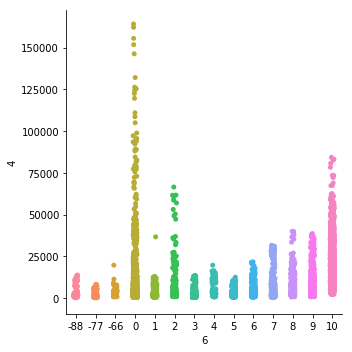

In [3]:
sns.catplot(x=6,y=4,data=df)

In [180]:
# transition_years = np.where(final_arr[:,-1]!=None)[0][1:]
transition_years = np.where(final_arr[:,-1]==3)[0][1:] # good times
# transition_years = np.where(final_arr[:,-1]==-2)[0][1:] # bad times
# transition_years = np.where(final_arr[:,-1]==-77)[0][1:] # state failure
# transition_years = np.where(final_arr[:,-1]==-66)[0][1:] # interruption
# transition_years = np.where(final_arr[:,-1]==99)[0][1:] # interruption

analysis_period = 7
transition_data = []
for j in range(transition_years.shape[0]):
    fill_arr = final_arr[range(max(1,transition_years[j]-analysis_period//2-1),min(final_arr.shape[0],transition_years[j]+1+analysis_period//2)),:]
    if fill_arr.shape[0]==analysis_period+1:
        transition_data.append(fill_arr)
transition_data = np.array(transition_data)
change_rgdppc = 100*np.divide(transition_data[:,:,4][:,1:] - transition_data[:,:,4][:,:-1],transition_data[:,:,4][:,:-1])
TRANSITION_DATA = reject_outliers(change_rgdppc)
TRANSITION_DATA.shape

(185, 7)

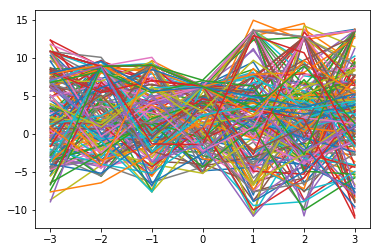

In [181]:
X = list(range(-3,4))
import matplotlib.pyplot as plt
for Y in TRANSITION_DATA:
    plt.plot(X,Y)

In [165]:
TRANSITION_DATA

array([[1.2271575781737025, 0.8010628273216667, -1.6358577633915836,
        -503.7532379182072, 11.308058704291758, -1.5978838344900725,
        -5.199116858079255],
       [4.697033059294894, 0.8631773951659698, 4.425376656794682,
        -503.7532379182072, 11.308058704291758, 14.066338328446362,
        -5.199116858079255],
       [2.608022250419416, -3.2581254495158696, -0.11213893356524915,
        -503.7532379182072, 1.700519348722814, -1.0884108020942593,
        -5.199116858079255],
       [3.2004869356149928, 1.26961903114108, 0.2486333948172863,
        -503.7532379182072, -0.9855524990460142, -4.867715740272299,
        -5.199116858079255],
       [4.484619820757221, 3.3222556400155345, 7.261336537740128,
        -503.7532379182072, -5.9194734783260445, 6.441986145009415,
        -5.199116858079255],
       [11.186989945094341, -1.3224946294787128, 5.333958901941471,
        -503.7532379182072, 11.308058704291758, 0.28055919478772695,
        -5.199116858079255],
       [5.

In [61]:
transition_data

array([[['Angola', 1988, 28204.390625, ..., 7, -7, None],
        ['Angola', 1989, 30350.27734375, ..., 7, -7, None],
        ['Angola', 1990, 32667.025390625, ..., 7, -7, None],
        ...,
        ['Angola', 1992, 30015.341796875, ..., -77, 0, -77],
        ['Angola', 1993, 27484.984375, ..., -88, -1, 1],
        ['Angola', 1994, 28932.923828125, ..., -88, -1, 1]],

       [['Angola', 1989, 30350.27734375, ..., 7, -7, None],
        ['Angola', 1990, 32667.025390625, ..., 7, -7, None],
        ['Angola', 1991, 26304.021484375, ..., -88, -3, -2],
        ...,
        ['Angola', 1993, 27484.984375, ..., -88, -1, 1],
        ['Angola', 1994, 28932.923828125, ..., -88, -1, 1],
        ['Angola', 1995, 25601.490234375, ..., -88, -2, 1]],

       [['Angola', 1990, 32667.025390625, ..., 7, -7, None],
        ['Angola', 1991, 26304.021484375, ..., -88, -3, -2],
        ['Angola', 1992, 30015.341796875, ..., -77, 0, -77],
        ...,
        ['Angola', 1994, 28932.923828125, ..., -88, -1, 1]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()